In [1]:
import pandas as pd
import numpy as np
import pymongo as pm
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import copy

In [2]:
client = pm.MongoClient()
bm = pd.DataFrame(client["Fields"]["股價淨值比"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
cl = pd.DataFrame(client["Fields"]["還原收盤價"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
bm = bm.reindex(sorted(bm.columns), axis=1)
cl = cl.reindex(sorted(cl.columns), axis=1)

In [3]:
bm_m = bm.resample("M").last()
cl_m = cl.resample("M").last()
bm_m = bm_m.subtract(bm_m.mean(axis=1), axis=0).divide(bm_m.std(axis=1), axis=0)
bm_m = bm_m.clip(-5, 5)

<AxesSubplot: >

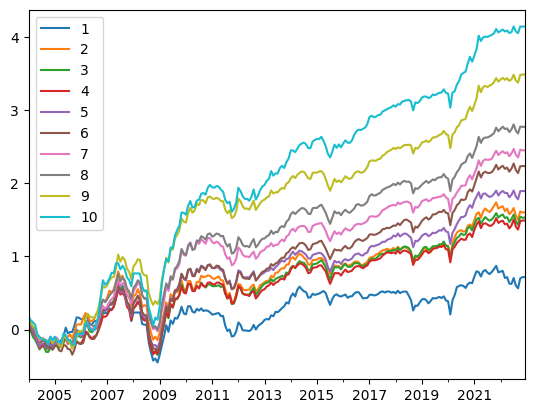

In [4]:
labels = list(range(10, 0, -1))
#labels = list(range(1, 11))
rt = pd.DataFrame()
for i, r in bm_m.iterrows():
    se = cl_m.pct_change().shift(-1).loc[i]
    rt = pd.concat([rt, se.groupby(pd.qcut(r, q=10, labels=labels)).mean()], axis=1)
rt = rt.T.reindex(sorted(rt.T.columns), axis=1)
rt.fillna(0).cumsum().plot()

虛無假設為因子收益率=0，T值不滿足下列條件則無法拒絕虛無假設
因子的T值須>2，嚴格要求的話要>3.8，此時T值為 4.58
秩相關係數: 0.93


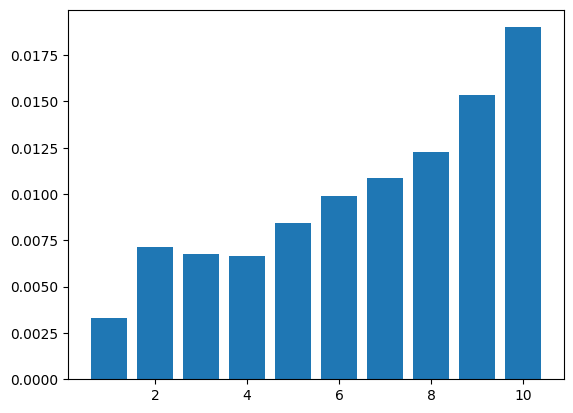

In [5]:
因子收益率 = rt[10].fillna(0) - rt[1].fillna(0)
收益率估計 = 因子收益率.mean()
標準誤 = 因子收益率.std()/np.sqrt(len(因子收益率))
t值 = 收益率估計/標準誤
print("虛無假設為因子收益率=0，T值不滿足下列條件則無法拒絕虛無假設")
print(f"因子的T值須>2，嚴格要求的話要>3.8，此時T值為 {t值:.2f}")

# 秩相關係數
rk = rt.mean(axis=0).corr(pd.Series(list(range(1, 11))), method="spearman")
print(f"秩相關係數: {rk:.2f}")
# 月均收益率
plt.bar(x=range(1, 11), height=rt.mean(axis=0))
plt.show()

In [6]:
stats.ttest_ind(rt.mean(axis=0).values, list(range(1, 11)))

Ttest_indResult(statistic=-5.734151210430238, pvalue=1.9513715410428463e-05)

## 雙重排序

In [7]:
bm = pd.DataFrame(client["Fields"]["股價淨值比"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
cl = pd.DataFrame(client["Fields"]["還原收盤價"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
cap = pd.DataFrame(client["Fields"]["總市值(億)"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
bm = bm.reindex(sorted(bm.columns), axis=1)
cl = cl.reindex(sorted(cl.columns), axis=1)
cap = cap.reindex(sorted(cap.columns), axis=1)

In [8]:
bm_m = bm.resample("M").last()
cl_m = cl.resample("M").last()
cap_m = cap.resample("M").last()
bm_m = bm_m.subtract(bm_m.mean(axis=1), axis=0).divide(bm_m.std(axis=1), axis=0)
bm_m = bm_m.clip(-5, 5)
cap_m = cap_m.subtract(cap_m.mean(axis=1), axis=0).divide(cap_m.std(axis=1), axis=0)
cap_m = cap_m.clip(-5, 5)


### 分群 重點區
1. 獨立雙重排序
2. 條件雙重排序

#### 1. 獨立雙重排序

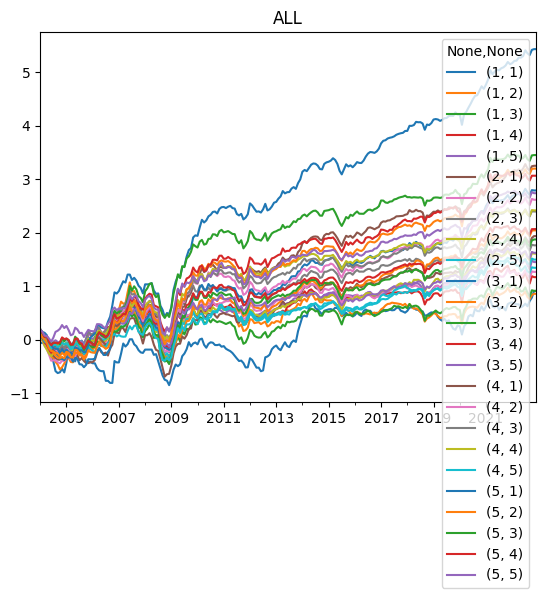

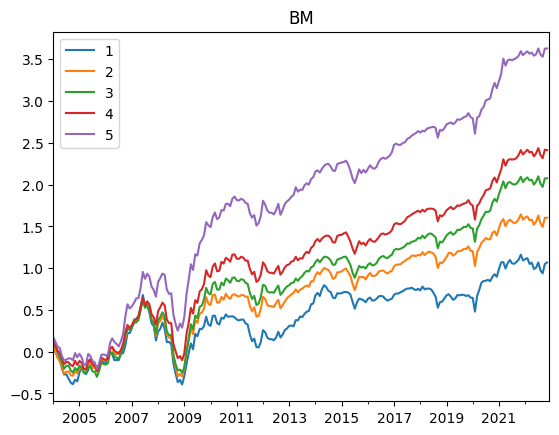

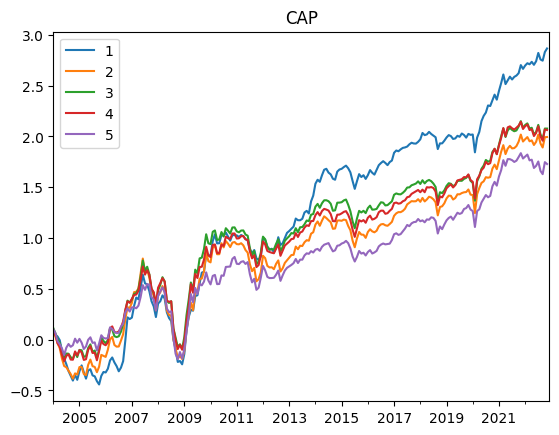

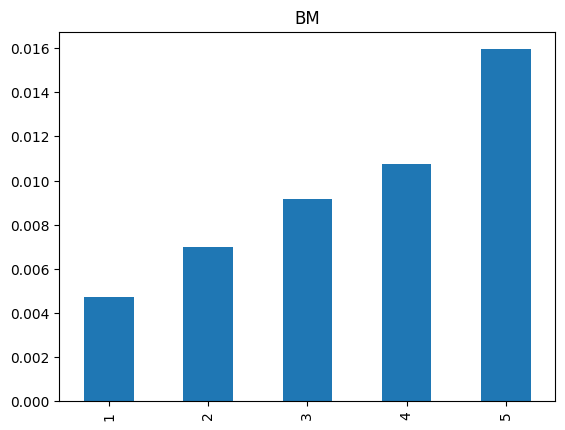

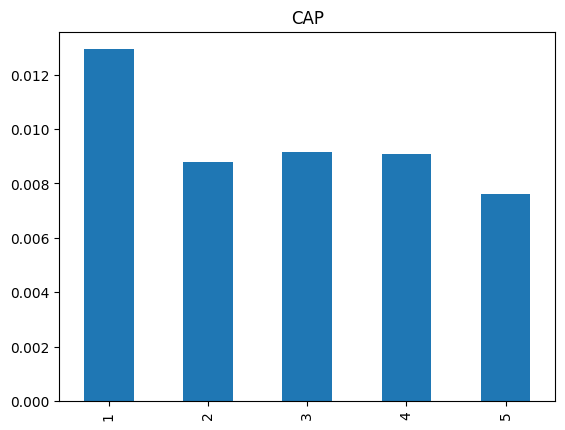

In [9]:
labels_x1 = list(range(5, 0, -1))
labels_x2 = list(range(1, 6, 1))
rt = []
for i, r in bm_m.iterrows():
    R = pd.Series(list(zip(
        pd.qcut(bm_m.loc[i], q=5, labels=labels_x1), # 5代表最便宜
        pd.qcut(cap_m.loc[i], q=5, labels=labels_x2))), # 5代表市值最大
    index=bm_m.columns)
    se = cl_m.pct_change().shift(-1).loc[i]
    rt.append(se.groupby(R).mean())
rt = pd.concat(rt, axis=1)
rt = rt.loc[rt.index.dropna()].T
rt = rt.reindex(sorted(rt.columns), axis=1)
rt.fillna(0).cumsum().plot(title="ALL")
plt.show()
# x1: bm效果 1 = 最貴 5 = 最便宜
rt.groupby(level=0, axis=1).mean().cumsum().plot(title="BM")
rt.groupby(level=1, axis=1).mean().cumsum().plot(title="CAP")
plt.show()

# x2: cap效果 1 = 小市值 5 = 大市值
rt.mean(axis=0).groupby(level=0, axis=0).mean().plot.bar(title="BM")
plt.show()
rt.mean(axis=0).groupby(level=1, axis=0).mean().plot.bar(title="CAP")
plt.show()

#### 條件雙重排序

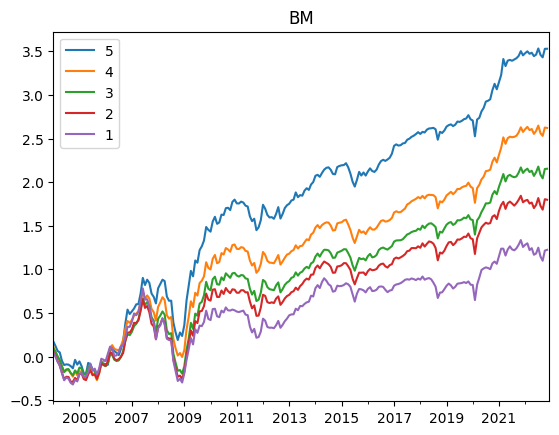

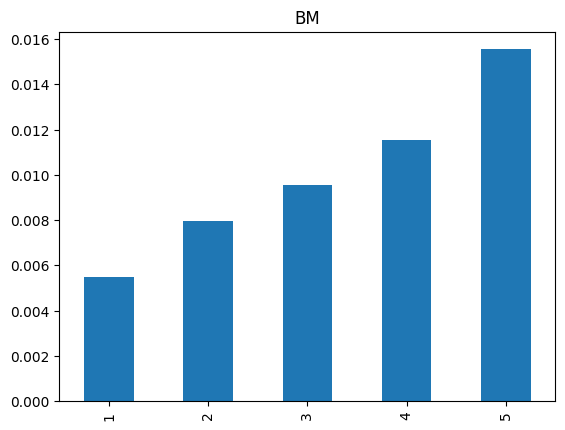

收益率估計: 0.010157405930059968


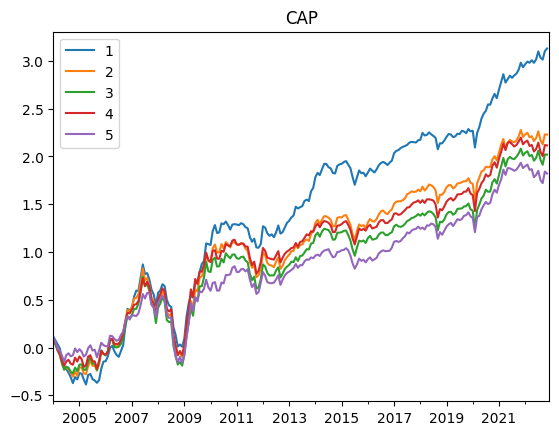

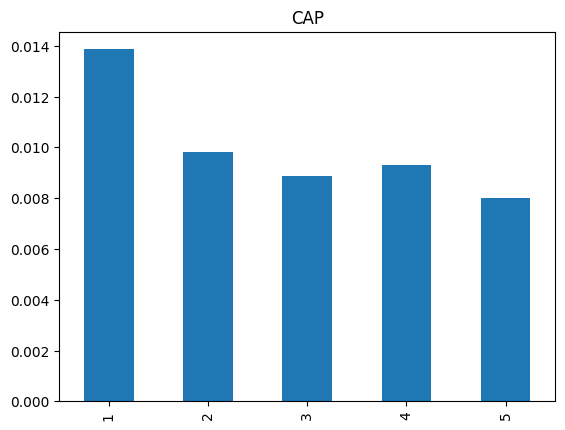

收益率估計: 0.005768066714312624


In [10]:
labels_x1 = list(range(5, 0, -1))
labels_x2 = list(range(1, 6, 1))

def second_group(s, i, m, l):
    # 每次資料丟進來都是優先分完一次的資料，將資料再次分群，靠的是.loc[i, s.index]，這邊s.index使這次分群只在分過一次的商品內
    se = s.groupby(pd.qcut(m.loc[i, s.index], q=5, labels=l)).mean()
    return se
##  X1 BM
rt = []
for i, r in bm_m.iterrows():
    se = cl_m.pct_change().shift(-1).loc[i]
    rt.append(se.groupby(pd.qcut(cap_m.loc[i], q=5, labels=labels_x2)).apply(second_group, i=i, m=bm_m, l=labels_x1))
rt = pd.concat(rt, axis=1)
rt = rt.loc[rt.index.dropna()].T
rt = rt.reindex(sorted(rt.columns), axis=1)
# x1: bm效果 1 = 最貴 5 = 最便宜
估計收益率 = (rt.groupby(level=1, axis=1).mean()[5] -rt.groupby(level=1, axis=1).mean()[1]).mean()
rt.groupby(level=1, axis=1).mean().cumsum().plot(title="BM")
plt.show()
rt.mean(axis=0).groupby(level=1, axis=0).mean().sort_index(ascending=False).plot.bar(title="BM")
plt.show()
print(f"收益率估計: {估計收益率}")
## X2 CAP
rt = []
for i, r in bm_m.iterrows():
    se = cl_m.pct_change().shift(-1).loc[i]
    rt.append(se.groupby(pd.qcut(bm_m.loc[i], q=5, labels=labels_x1)).apply(second_group, i=i, m=cap_m, l=labels_x2))
rt = pd.concat(rt, axis=1)
rt = rt.loc[rt.index.dropna()].T
rt = rt.reindex(sorted(rt.columns), axis=1)
# x2: cap效果 1 = 小市值 5 = 大市值
估計收益率 = (rt.groupby(level=1, axis=1).mean()[1] -rt.groupby(level=1, axis=1).mean()[5]).mean()
rt.groupby(level=1, axis=1).mean().cumsum().plot(title="CAP")
plt.show()
rt.mean(axis=0).groupby(level=1, axis=0).mean().sort_index(ascending=True).plot.bar(title="CAP")
plt.show()
print(f"收益率估計: {估計收益率}")



In [29]:
rt.groupby(level=1, axis=1).mean()[1] - rt.groupby(level=1, axis=1).mean()[5]


2004-01-31    0.013095
2004-02-29   -0.000872
2004-03-31    0.032700
2004-04-30   -0.017919
2004-05-31   -0.058063
                ...   
2022-08-31    0.031481
2022-09-30    0.011099
2022-10-31   -0.033094
2022-11-30    0.049453
2022-12-31         NaN
Length: 228, dtype: float64

In [41]:
print(f"時序因子收益率 {chr(955)}t")
print(f"Rit = {chr(945)}i + {chr(946)}i{chr(955)}t + {chr(949)}it")
lambda_t = rt.groupby(level=1, axis=1).mean()[1] - rt.groupby(level=1, axis=1).mean()[5]
cl_m.pct_change().shift(-1)["1101"]

時序因子收益率 λt
Rit = αi + βiλt + εit


日期
2004-01-31    0.085774
2004-02-29   -0.078998
2004-03-31   -0.225941
2004-04-30    0.072973
2004-05-31   -0.005038
                ...   
2022-08-31   -0.139949
2022-09-30   -0.105030
2022-10-31    0.120661
2022-11-30    0.011799
2022-12-31         NaN
Freq: M, Name: 1101, Length: 228, dtype: float64

In [65]:
(cl_m.pct_change().shift(-1)["1101"].subtract(cl_m.pct_change().shift(-1)["1101"].mean()) * \
lambda_t.subtract(lambda_t.mean())).sum()
#(cl_m.pct_change().shift(-1)["1101"] * lambda_t).sum() - cl_m.pct_change().shift(-1)["1101"].mean()*lambda_t.mean()
def calculate_beta(x, y):
    return np.cov(x.fillna(0), y.fillna(0))[0, 1] / np.var(y)

beta = {}
for _, i in cl_m.pct_change().shift(-1).items():
    beta[_] = calculate_beta(i, lambda_t)

c:\Users\ChastLai\Documents\Python Scripts\Chast\venv1\lib\site-packages\numpy\lib\function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [66]:
beta

{'1101': -0.5899294006818937,
 '1102': -0.6019472644980361,
 '1103': -0.4409321030823246,
 '1104': -0.20274241483592284,
 '1107': 0.34347639680275394,
 '1108': 0.02577196112740107,
 '1109': -0.11690893760978818,
 '1110': 0.012895784281217772,
 '1113': 0.0,
 '1201': -0.11169092553371601,
 '1203': -0.07852369758193002,
 '1204': 0.02136195191855498,
 '1206': 0.0,
 '1207': 0.3345090335342081,
 '1208': 0.0,
 '1209': 0.0,
 '1210': -0.26512777778259794,
 '1212': nan,
 '1213': -0.027036342065619442,
 '1214': 0.0,
 '1215': 0.046767809943891035,
 '1216': -0.37260329777991624,
 '1217': -0.28337580214124686,
 '1218': -0.29557967680972813,
 '1219': 0.22829201698678092,
 '1220': 0.3756385331818726,
 '1221': 0.0,
 '1222': 0.0,
 '1224': nan,
 '1225': 0.20952398574683015,
 '1226': 0.0,
 '1227': -0.02004929653734682,
 '1228': -0.009426108958544054,
 '1229': -0.4321475147297658,
 '1230': 0.0,
 '1231': -0.12426372465597409,
 '1232': 0.023224632697937467,
 '1233': -0.0041348559974998264,
 '1234': -0.153491

In [62]:
cl_m.pct_change().shift(-1).items()

<generator object DataFrame.items at 0x0000018F8997ECF0>

In [61]:
np.cov(cl_m.pct_change().shift(-1)["6505"].fillna(0), lambda_t.fillna(0))[0, 1] / np.var(lambda_t)
#np.var(lambda_t)

-0.2125011558480396

In [56]:
np.var(cl_m.pct_change().shift(-1)["1101"].fillna(0))

0.007878469846105537

In [21]:
print(f"這個表示為CAP的因子收益率{chr(955)} = ", 估計收益率)
print(f"E[{chr(955)}] = {估計收益率:.4f}*{chr(946)}")
print(f"代入個股的平均月收益就可以算出 {chr(946)}")
returns = cl_m.pct_change().shift(-1)
returns = returns.mean(axis=0)
beta = returns / 估計收益率
beta # 每檔股票的因子暴露

這個表示為CAP的因子收益率λ =  0.005768066714312624
E[λ] = 0.0058*β
代入個股的平均月收益就可以算出 β


1101    2.201918
1102    2.227809
1103    1.132226
1104    1.788751
1107    0.549595
          ...   
9951    2.202391
9955    1.582788
9958    3.574847
9960    2.197156
9962    2.101840
Length: 2211, dtype: float64

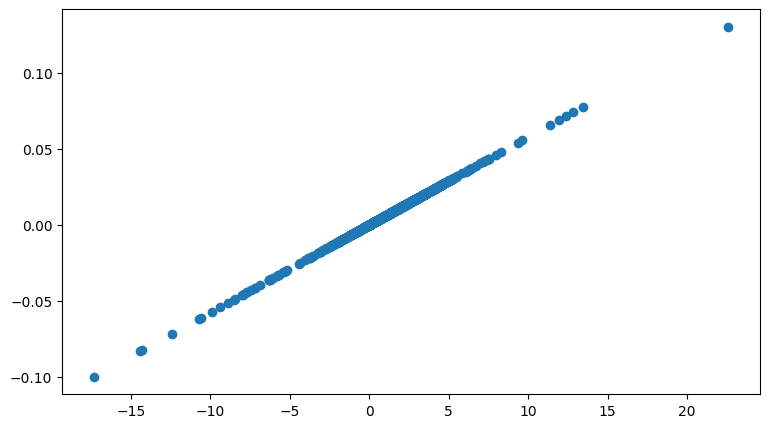

In [24]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x=beta.values, y=returns.values)

In [12]:
rt.groupby(level=1, axis=1).mean()[1] - rt.groupby(level=1, axis=1).mean()[5]

2004-01-31    0.013095
2004-02-29   -0.000872
2004-03-31    0.032700
2004-04-30   -0.017919
2004-05-31   -0.058063
                ...   
2022-08-31    0.031481
2022-09-30    0.011099
2022-10-31   -0.033094
2022-11-30    0.049453
2022-12-31         NaN
Length: 228, dtype: float64

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from scipy.stats import f


def GRS_test(factor, resid, alpha):
    N = resid.shape[1]
    T = resid.shape[0]
    L = factor.shape[1]

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1)
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.inv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.inv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs